Nilearn pipeline for task-based connectivity analysis
===============================================================

Step 1: Loading libraries
------------------------------------

In [9]:
import numpy as np
import pandas as pd
import os
import glob

import nilearn
from nilearn import datasets, plotting, input_data, signal # datasets: for fetching atlas
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_design_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
nilearn.__version__

'0.5.0a'

Step 2: Setting paths to data
----------------------------------

In [16]:
main_folder = '/home/finc/Dropbox/GitHub/nilearn_task_networks/'
top_dir = '/media/finc/Elements1/extracted_HCPWM/'

fmri_list = glob.glob(top_dir + '1*/**/tfMRI_WM_RL.nii.gz', recursive=True) # if you want all tfMRI_WM_RL.nii.gz files hanging from topdir
confounds_list = glob.glob(top_dir + '1*/**/Movement_Regressors.txt', recursive=True)

fmri_list = sorted(fmri_list)
confounds_list = sorted(confounds_list)

print(f'Number of subjects: {len(fmri_list)}')

Number of subjects: 35


Step 3: Creating parcellation
-------------------------------------------

In [18]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds=power_coords, 
    smoothing_fwhm=6, 
    radius=5,
    detrend=True, 
    standardize=True,
    low_pass=0.08, 
    high_pass=0.009,
    t_r=0.72
)

parcellation = power_spheres

Step 4: Extracting timeseries
-------------------------------------------

In [19]:
# Create empty timeseries to store array
timeseries_all = np.zeros((len(fmri_list), 405, 264)) 

for sub in range(len(fmri_list)):
             
    # Load confound file
    confounds = np.loadtxt(confounds_list[sub])
        
    # Extract timeseries
    timeseries = parcellation.fit_transform(fmri_list[sub], confounds = confounds)
    
    # Save timeseries to array
    timeseries_all[sub, :, :] = timeseries
    
timeseries_all.shape    

(35, 405, 264)

In [20]:
#np.save('/home/finc/Dropbox/GitHub/HCP_correlation_matrices_power.py', timeseries_all)

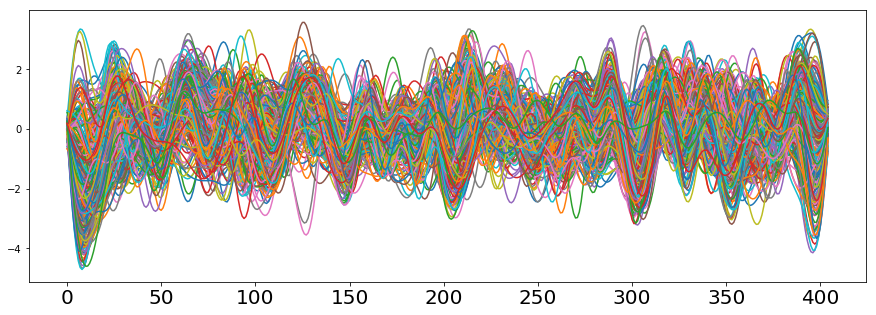

In [20]:
# plotting timeseries

plt.figure(figsize = (15, 5))

_ = plt.plot(timeseries_all[0,:,:])

Step 5: Generating design matrix
----------------------------------------------

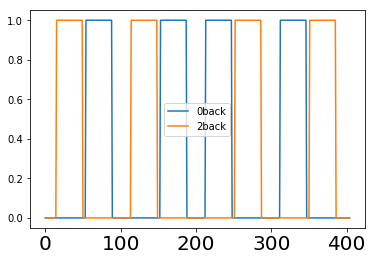

In [21]:
t_r = 0.72
n_scans = 405

onsets_dir = '/home/finc/Dropbox/GitHub/nilearn_task_networks/support/onsets_HCP.csv'

events = pd.read_csv(onsets_dir)
events

frame_times = np.arange(n_scans) * t_r
frame_times

design_matrix = make_design_matrix(frame_times, events, hrf_model = None)
design_matrix = design_matrix.reset_index()


plt.plot(design_matrix['0back'])
plt.plot(design_matrix['2back'])
plt.legend()

Step 6: Calculating correlation matrices
---------------------------------------------

In [23]:
conditions  = ['0back', '2back']
sub_n = timeseries_all.shape[0]
rois_n = timeseries_all.shape[2]

correlation_matrices = np.zeros((sub_n, len(conditions), rois_n, rois_n))

for sub in range(sub_n):
    for i, cond in enumerate(conditions):
    
        task = timeseries_all[sub, design_matrix[cond].astype('bool').astype('bool'), :]
        
        correlation_measure = ConnectivityMeasure(kind='correlation')
    
        fc = correlation_measure.fit_transform([task])[0]
        np.fill_diagonal(fc, 0)
        
        correlation_matrices[sub, i, :, :] = fc


correlation_matrices.shape

(35, 2, 264, 264)

Step 7: Calculating edge-wise differences
---------------------------------------------

In [43]:
from scipy import stats
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix

zero_back = sym_matrix_to_vec(correlation_matrices[:,0,:,:], discard_diagonal = True)
two_back = sym_matrix_to_vec(correlation_matrices[:,1,:,:], discard_diagonal = True)

stat, pvalues = stats.ttest_rel(zero_back, two_back)

import statsmodels.stats.multitest as ssm

_, pvals_corrected, _, _ = ssm.multipletests(pvalues, alpha = 0.05, method = 'fdr_bh')

pvals_corrected_thr = np.zeros((len(pvals_corrected)))

pvals = np.array([0 if p >= 0.05 else 1 for p in pvals_corrected])
sum(pvals)

1136

In [52]:
wei_vector = stat * pvals 
diag = np.zeros((264))

matrix_wei = vec_to_sym_matrix(wei_vector, diagonal = diag)
matrix_bin = vec_to_sym_matrix(pvals, diagonal = diag)

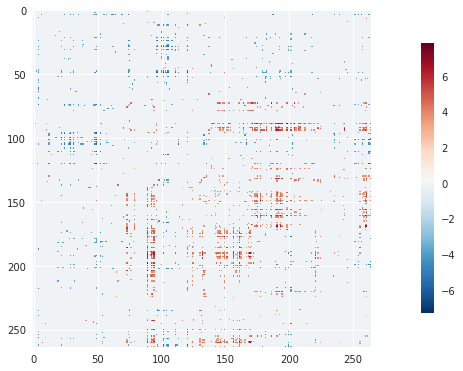

In [51]:
plotting.plot_matrix(matrix_wei)

In [57]:
from functions import networks

modules = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/code/modules.txt', sep = " ", header = None)
lsn = modules[0].values

networks = calculate_lsn_edges(matrix_bin, lsn)

In [58]:
# separate network for positive and negative differences

bin_vector_pos =  np.array([1 if thr > 0 else 0 for thr in wei_vector])
bin_vector_neg =  np.array([1 if thr < 0 else 0 for thr in wei_vector])

diag = np.zeros((264))
bin_matrix_pos = vec_to_sym_matrix(bin_vector_pos, diagonal = diag)
bin_matrix_neg = vec_to_sym_matrix(bin_vector_neg, diagonal = diag)

networks_pos = calculate_lsn_edges(bin_matrix_pos, lsn)
networks_neg = calculate_lsn_edges(bin_matrix_neg, lsn)

Text(0.5,1,'2-back > 0-back')

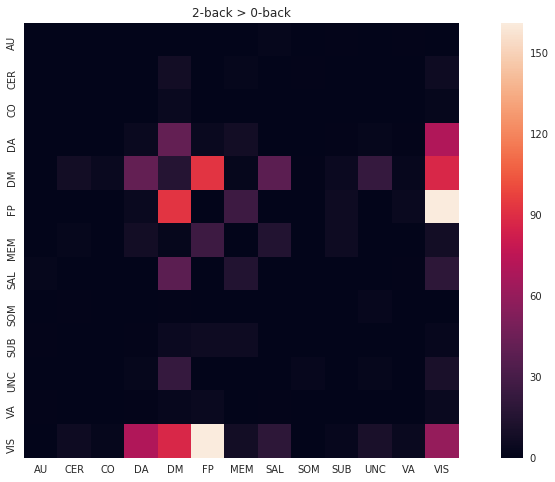

In [59]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,8))
sns.heatmap(networks_pos, yticklabels = labels, xticklabels = labels, square = True).set_title('2-back > 0-back')


Text(0.5,1,'0-back > 2-back')

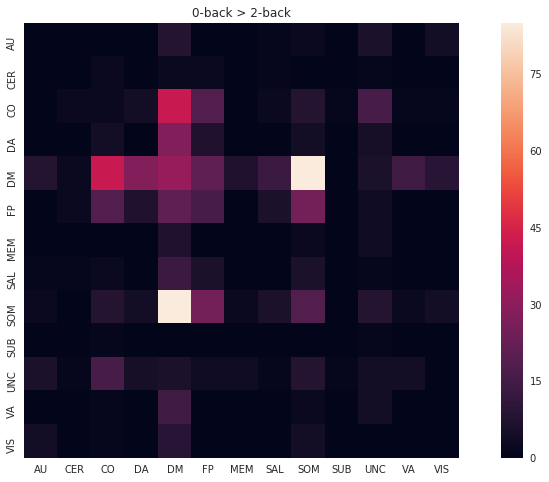

In [60]:
plt.figure(figsize=(15,8))
sns.heatmap(networks_neg, yticklabels = labels, xticklabels = labels, square = True).set_title('0-back > 2-back')

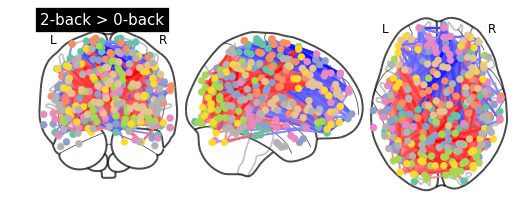

In [62]:
plotting.plot_connectome(matrix_wei, power_coords, title = '2-back > 0-back')


In [63]:
view = plotting.view_connectome(matrix_wei, power_coords, threshold = '99%')
view

Step 8: Creating parcellation from task activations
------------------------------------------------------

Number of coordinates before cleaning: 45
Number of coordinates after cleaning: 27


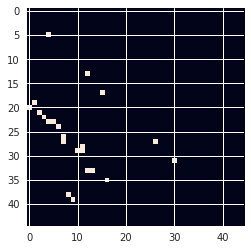

In [64]:
from sklearn import neighbors

# Loading coordinates from activation analysis
activ = pd.read_csv('/home/finc/Dropbox/GitHub/nilearn_task_networks/support/coordinates_0back_2back.csv')

activ_coords = pd.DataFrame(activ, columns = ['X', 'Y', 'Z']).values

radius = 10

# Estimate neighbors
clf = neighbors.NearestNeighbors(radius = radius)

# Compute neighborhood matrix
A = clf.fit(activ_coords).radius_neighbors_graph().toarray()
A = np.tril(A, 0)

# Plot lower triangle of neighborhood matrix
plt.imshow(A)

# Select coordinates to keep
selector = A.sum(axis=1) == 0

# Create final object
activ_clean = activ_coords[selector]

print(f"Number of coordinates before cleaning: {len(activ_coords)}")
print(f"Number of coordinates after cleaning: {len(activ_clean)}")
                                                   


In [65]:
# Creating masker file

activ_spheres = input_data.NiftiSpheresMasker(
    seeds = activ_clean, 
    smoothing_fwhm = None, 
    radius = 5,
    detrend = True, 
    standardize = True,
    low_pass = 0.08, 
    high_pass = 0.009,
    t_r = 0.72
)

parcellation = activ_spheres

In [ ]:
# Create empty timeseries to store array
timeseries_all_activ = np.zeros((len(fmri_list), 405, 27)) 

for sub in range(len(fmri_list)):
             
    # Load confound file
    confounds = np.loadtxt(confounds_list[sub])
        
    # Extract timeseries
    timeseries = parcellation.fit_transform(fmri_list[sub], confounds = confounds)
    
    # Save timeseries to array
    timeseries_all_activ[sub, :, :] = timeseries
    
    

In [59]:
timeseries_all_activ.shape

()

In [53]:
import numpy as np

def calculate_lsn_edges (A, labels):
    """Function calculates number of edges between and within predefined large-scale networks (LSNs).
    The function takes binary symetrical adjacency matrix, module assignment of each ROI and calculate number of edges between and within each
    large-scale network.

    Parameters
    ------------
    array: N x N binary ajdacency matrix
    array: N-length vector with module assignment for each node

    Returns
    ------------
    array: M x M matrix with number of edges between each module

    """
    columns = np.unique(labels)
    lsn_matrix = np.zeros((len(A), len(columns)))
    lsn_edges = np.zeros((len(columns), len(columns)))

    for col in range(len(columns)):
        module = columns[col, ]
        for row in range(len(labels)):
            if (labels[row, ] == module):
                lsn_matrix[row, col] = 1
            else:
                lsn_matrix[row, col] = 0

    lsn_edges = lsn_matrix.T @ A @ lsn_matrix
    return lsn_edges
